In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display

# Import NMF từ sklearn
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.datasets import fetch_olivetti_faces # Dùng cho phần ứng dụng
from numpy.linalg import norm

## 1. Chuẩn Forbenius

### 1.1 Ứng dụng: Chuẩn Frobenius trong Huấn luyện Mạng Nơ-ron (MNIST)

+ Trong bài toán phân loại ảnh MNIST, **chuẩn Frobenius** ($\|\cdot\|_F$) không chỉ là một công thức toán học thuần túy mà được áp dụng trực tiếp vào quá trình tối ưu hóa mô hình theo hai cách chính:

   1.  **Thành phần của Hàm mất mát (Regularization):**

       * Đóng vai trò là **L2 Regularization** (Weight Decay) để ràng buộc các trọng số lớn, giúp mô hình tránh hiện tượng quá khớp (overfitting).
      
       * Công thức: $\mathcal{L}_{reg} = \lambda \lVert \mathbf{W} \rVert_F^2 = \lambda \sum_{i,j} |w_{ij}|^2$.

   2.  **Tiêu chí trong các thuật toán đặc thù:**
       * Sử dụng trong các phương pháp nén mô hình hoặc các bộ phân loại dựa trên khoảng cách (ví dụ: *Quantum Frobenius Distance Classifier*).

---
**Dưới đây là kết quả thực nghiệm huấn luyện mô hình sử dụng chuẩn Frobenius làm thành phần điều chuẩn (L2 Regularization):**

#### 1.1.1 Chuẩn bị bộ dữ liệu, huấn luyện và đánh giá mô hình

In [2]:
# 1. Thiết lập Hyperparameters và Bộ điều chuẩn (Lambda)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 64
# THÀNH PHẦN QUAN TRỌNG: Weight Decay (Tỷ lệ cho Chuẩn Frobenius)
WEIGHT_DECAY = 1e-4 # Lambda (λ) cho L2 Regularization

# 2. Tải và Xử lý dữ liệu MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 3. Định nghĩa Mô hình Mạng nơ-ron
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # 28*28 = 784 đầu vào (ảnh phẳng)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN().to(DEVICE)

# 4. Định nghĩa Loss và Optimizer
# Hàm mất mát CrossEntropyLoss là tiêu chuẩn cho phân loại.
criterion = nn.CrossEntropyLoss()

# Optimizer Adam sẽ tự động thêm L2 Regularization (bình phương Chuẩn Frobenius)
# lên tất cả các ma trận trọng số (weights) thông qua tham số weight_decay.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 5. Vòng lặp Huấn luyện
print(f"Bắt đầu huấn luyện với L2 Regularization (Chuẩn Frobenius bình phương): {WEIGHT_DECAY}")
for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        # Forward
        scores = model(data)

        # Tính toán mất mát
        loss = criterion(scores, targets)

        # Mất mát cuối cùng = CrossEntropyLoss + (WEIGHT_DECAY * bình phương Chuẩn Frobenius của W)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Cập nhật trọng số (đã bao gồm phạt chuẩn Frobenius)
        optimizer.step()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}")

print("Quá trình huấn luyện hoàn tất.")

Bắt đầu huấn luyện với L2 Regularization (Chuẩn Frobenius bình phương): 0.0001
Epoch [1/10], Loss: 0.0548
Epoch [2/10], Loss: 0.2694
Epoch [3/10], Loss: 0.0254
Epoch [4/10], Loss: 0.0021
Epoch [5/10], Loss: 0.0262
Epoch [6/10], Loss: 0.4957
Epoch [7/10], Loss: 0.0317
Epoch [8/10], Loss: 0.0171
Epoch [9/10], Loss: 0.0036
Epoch [10/10], Loss: 0.0134
Quá trình huấn luyện hoàn tất.


#### 1.1.2. Hiển thị các nhãn và dự đoán tương ứng của mô hình

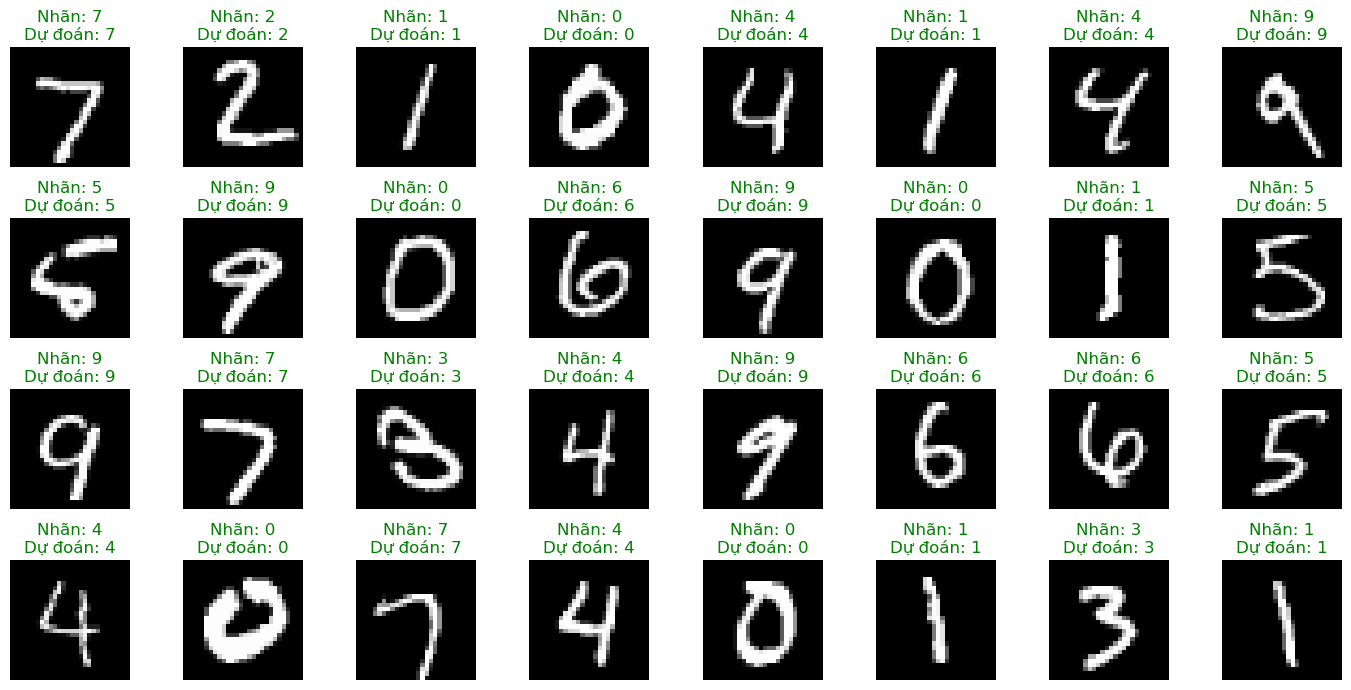

In [3]:
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# Tải một batch dữ liệu kiểm thử
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to("cpu")
labels = labels.to("cpu")
model.to("cpu")
with torch.no_grad():
    scores = model(images)
    _, predictions = scores.max(dim=1)
fig, axes = plt.subplots(4, 8, figsize=(14, 7))
axes = axes.flatten()

for i in range(32):
    # Loại bỏ chiều kênh (channel dimension) để hiển thị ảnh xám
    img = images[i].squeeze()
    # Hiển thị ảnh
    axes[i].imshow(img, cmap='gray')
    # Thiết lập tiêu đề với nhãn và dự đoán
    true_label = labels[i].item()
    pred_label = predictions[i].item()

    color = 'green' if true_label == pred_label else 'red'

    axes[i].set_title(f"Nhãn: {true_label}\nDự đoán: {pred_label}", color=color)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

#### 1.1.3 Hiển thị và trực quan hóa 32 bộ lọc trọng số

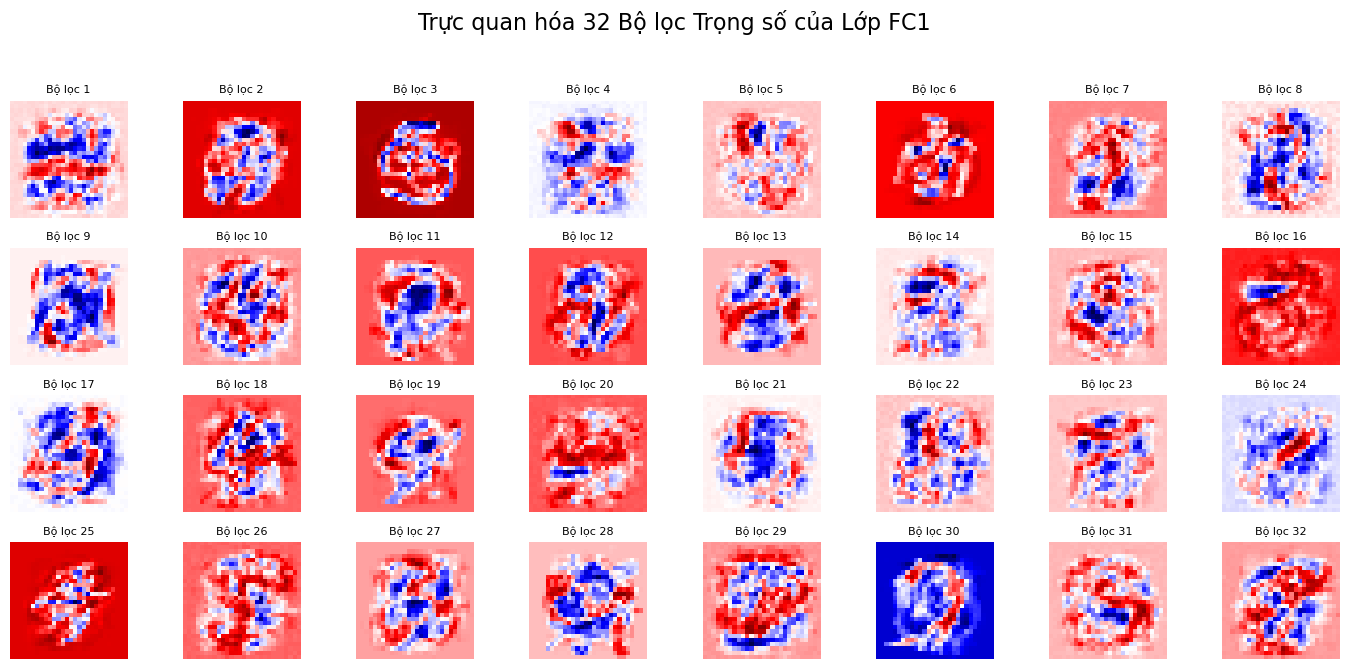

In [4]:
# Trực quan hóa Trọng số (Lớp Đầu tiên)
# W chính là ma trận mà chúng ta đã điều chỉnh bằng Chuẩn Frobenius

weights = model.fc1.weight.data.cpu()

# Trực quan hóa 32 bộ lọc đầu tiên (mỗi bộ lọc là 28x28)
num_filters_to_show = 32
fig, axes = plt.subplots(4, 8, figsize=(14, 7))
axes = axes.flatten()

for i in range(num_filters_to_show):
    # Lấy hàng thứ i của ma trận W (filter i)
    filter_i = weights[i, :].view(28, 28).numpy()

    # Hiển thị bộ lọc
    axes[i].imshow(filter_i, cmap='seismic')
    axes[i].set_title(f"Bộ lọc {i+1}", fontsize=8)
    axes[i].axis('off')

plt.suptitle(f"Trực quan hóa {num_filters_to_show} Bộ lọc Trọng số của Lớp FC1", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

###  1.2 Các Ứng dụng thực tế khác 

1. Giảm chiều Dữ liệu và Tái tạo Ảnh (Image Reconstruction)
   + Mục tiêu: Nén ma trận ảnh pixel $V$ (kích thước lớn) thành hai ma trận nhỏ hơn $W$ và $H$, sao cho tích $WH$ xấp xỉ $V$ với sai số nhỏ nhất.
      $$  \min_{W, H \ge 0} \|V - WH\|_F^2$$
   + Ví dụ: Nhận dạng khuôn mặt. Frobenius Loss cho phép NMF học một bộ ảnh cơ sở (Basis Images)  (là các cột của $W$ hoặc các hàng của $H$) đại diện cho các đặc trưng khuôn mặt cơ bản (như mắt, mũi, cằm).
   + Cơ chế: Vì Frobenius Loss tương đương với việc tối thiểu hóa Sai số Bình phương Trung bình (MSE), nó tìm kiếm các ma trận $W$ và $H$ sao cho sự khác biệt tổng thể giữa ảnh gốc và ảnh tái tạo là nhỏ nhất. Điều này tạo ra ảnh tái tạo mượt mà (smooth).

2. Trích xuất Đặc trưng cho Phân loại (Feature Extraction for Classification)
   + Frobenius NMF được sử dụng như một bước tiền xử lý mạnh mẽ.
   + Chuyển đổi dữ liệu: Sau khi huấn luyện, ma trận hệ số $W$ (hay còn gọi là ma trận mã hóa) chứa các đặc trưng mới, đã được giảm chiều, của khuôn mặt. Ví dụ: một ảnh khuôn mặt $784$ pixel được chuyển thành một vector đặc trưng $32$ chiều trong $W$.
   + Phân loại: Vector đặc trưng này sau đó được đưa vào các thuật toán phân loại có giám sát (như SVM hoặc Neural Network) để thực hiện nhận dạng khuôn mặt hoặc phân loại cảm xúc (ví dụ: khuôn mặt này thuộc về người A hay người B?).

3. Khả năng Chịu nhiễu Gaussian (Noise Reduction)
   + Cơ chế: Do Frobenius Loss dựa trên giả định sai số tuân theo phân phối chuẩn (Gaussian noise), NMF tối ưu hóa theo Loss này có xu hướng giảm thiểu hiệu quả các loại nhiễu có tính chất phân tán đồng đều.
   + Ứng dụng: NMF-Frobenius thường được sử dụng trong các bước tiền xử lý để giảm nhiễu (denoising)  hoặc loại bỏ các biến động cường độ nhỏ trong ảnh, giúp các đặc trưng khuôn mặt chính trở nên nổi bật hơn.
   + Frobenius Norm là lựa chọn an toàn và ổn định khi bạn cần một phương pháp NMF để nén dữ liệu ảnh và tạo ra các thành phần cơ sở mang tính trung bình và tổng thể của khuôn mặt.
   
-----

#### 1.2.1 Ứng dụng: Giảm chiều dữ liệu và tái tạo Ảnh (Image Reconstruction)

+  Khả năng Tạo ảnh và Tái tạo ảnh (PCA/SVD). Đây là ứng dụng cốt lõi của Chuẩn Frobenius trong đại số tuyến tính.
+  Mục đích: Đo lường lỗi xấp xỉ khi giảm chiều dữ liệu ảnh (ma trận $A$) bằng cách chỉ giữ lại $k$ thành phần quan trọng nhất (ma trận $A_k$ có hạng thấp).
+  Vai trò của Chuẩn Frobenius: Chuẩn Frobenius được sử dụng trong hàm mục tiêu của Phân tích Giá trị Suy biến (SVD) hoặc Phân tích Thành phần Chính (PCA) để tìm ra ma trận $A_k$ tốt nhất, sao cho lỗi tái tạo $\lVert A - A_k \rVert_F$ là nhỏ nhất.

--- PHẦN 1: Tái tạo ảnh và Lỗi Chuẩn Frobenius ---
Lỗi tái tạo với hạng k=1: 3643.82
Lỗi tái tạo với hạng k=5: 3111.04
Lỗi tái tạo với hạng k=25: 1195.24


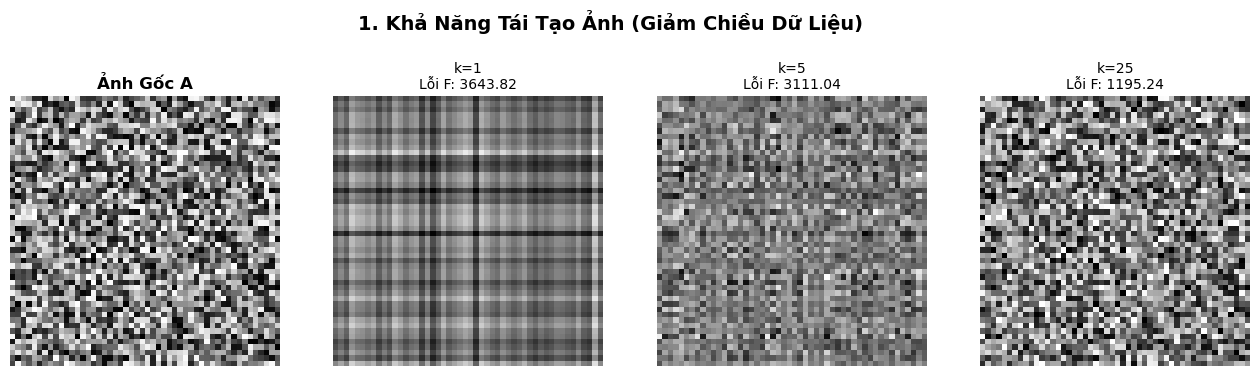

In [5]:
# Kích thước ảnh giả định (50x50 pixel)
IMAGE_SIZE = (50, 50)
np.random.seed(42)

# Ma trận A: Ảnh Gốc (Mô phỏng Khuôn mặt)
A = np.random.rand(*IMAGE_SIZE) * 255

print("--- PHẦN 1: Tái tạo ảnh và Lỗi Chuẩn Frobenius ---")

# 1. Phân tích giá trị suy biến (SVD)
U, S, Vt = np.linalg.svd(A, full_matrices=False)

# 2. Chọn các hạng k khác nhau để tái tạo ảnh
k_values = [1, 5, 25]
reconstructed_images = []
errors = []

for k in k_values:
    # Tái tạo ma trận xấp xỉ Ak (rank-k approximation)
    S_k = np.diag(S[:k])
    A_k = U[:, :k] @ S_k @ Vt[:k, :]

    # 3. Tính Lỗi Tái tạo bằng Chuẩn Frobenius
    # Lỗi = ||A - Ak||_F
    error = np.linalg.norm(A - A_k, 'fro')

    reconstructed_images.append(A_k)
    errors.append(error)

    print(f"Lỗi tái tạo với hạng k={k}: {error:.2f}")


# [TRỰC QUAN HÓA 1] Hiển thị ảnh gốc và các ảnh tái tạo
fig, axes = plt.subplots(1, len(k_values) + 1, figsize=(16, 4))
axes[0].imshow(A, cmap='gray')
axes[0].set_title('Ảnh Gốc A', fontweight='bold')
axes[0].axis('off')

for i, k in enumerate(k_values):
    ax = axes[i + 1]
    # np.clip và astype(np.uint8) để hiển thị ma trận pixel
    img_display = np.clip(reconstructed_images[i], 0, 255).astype(np.uint8)
    ax.imshow(img_display, cmap='gray')
    ax.set_title(f'k={k}\nLỗi F: {errors[i]:.2f}', fontsize=10)
    ax.axis('off')

plt.suptitle('1. Khả Năng Tái Tạo Ảnh (Giảm Chiều Dữ Liệu)', y=1.05, fontweight='bold', fontsize=14)
plt.show()

# Lưu trữ dữ liệu cho các cell sau
globals().update({'A': A, 'B': np.clip(A + np.random.randn(*IMAGE_SIZE) * 5, 0, 255), 'C': np.random.rand(*IMAGE_SIZE) * 255, 'U': U, 'S': S, 'Vt': Vt, 'k_values_part1': k_values, 'errors_part1': errors})

##### 1.2.1.1 Mở rộng: Phổ Giá trị Suy biến (SVD Spectrum)
+ Mục đích: Trực quan hóa Phổ giá trị suy biến (Singular Value Spectrum) để giải thích tại sao $k$ thành phần đầu tiên lại quan trọng nhất trong việc tái tạo ảnh (giảm thiểu lỗi Frobenius).

--- PHẦN MỞ RỘNG 1: Phổ Giá trị Suy biến (SVD Spectrum) ---


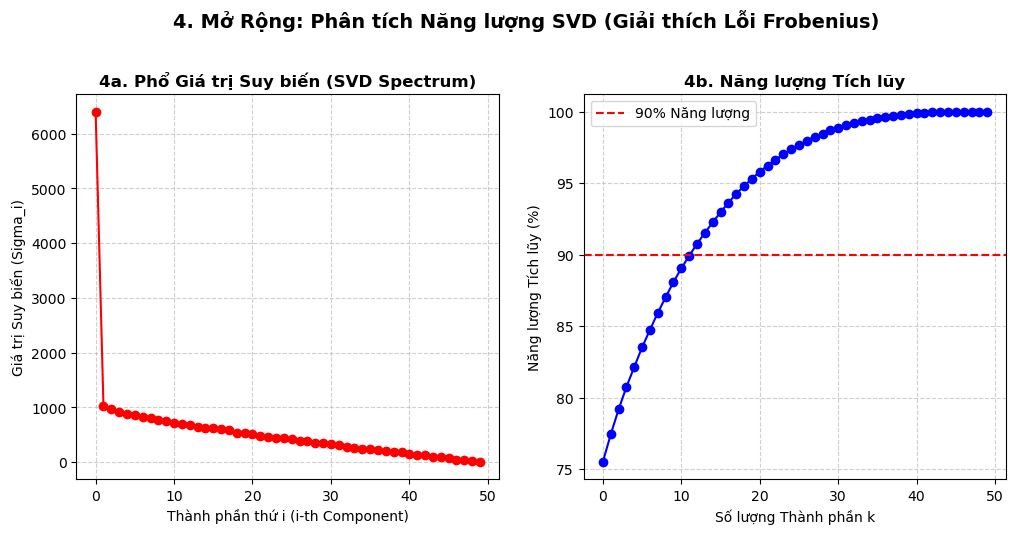


Giải thích: Chỉ cần giữ lại k=13 thành phần (chiếm khoảng 90% năng lượng) để tái tạo ảnh với lỗi Chuẩn Frobenius chấp nhận được.


In [6]:

print("--- PHẦN MỞ RỘNG 1: Phổ Giá trị Suy biến (SVD Spectrum) ---")
singular_values = S

# 1. Tính Tỷ lệ năng lượng tích lũy (Cumulative Energy)
total_energy = np.sum(singular_values**2)
cumulative_energy = np.cumsum(singular_values**2) / total_energy * 100

# 2. Trực quan hóa Phổ Giá trị Suy biến
plt.figure(figsize=(12, 5))

# Biểu đồ 1: Phổ giá trị suy biến
ax1 = plt.subplot(1, 2, 1)
ax1.plot(singular_values, marker='o', linestyle='-', color='red')
ax1.set_title('4a. Phổ Giá trị Suy biến (SVD Spectrum)', fontweight='bold')
ax1.set_xlabel('Thành phần thứ i (i-th Component)')
ax1.set_ylabel('Giá trị Suy biến (Sigma_i)')
ax1.grid(True, linestyle='--', alpha=0.6)

# Biểu đồ 2: Năng lượng Tích lũy
ax2 = plt.subplot(1, 2, 2)
ax2.plot(cumulative_energy, marker='o', linestyle='-', color='blue')
ax2.axhline(90, color='red', linestyle='--', label='90% Năng lượng')
ax2.set_title('4b. Năng lượng Tích lũy', fontweight='bold')
ax2.set_xlabel('Số lượng Thành phần k')
ax2.set_ylabel('Năng lượng Tích lũy (%)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('4. Mở Rộng: Phân tích Năng lượng SVD (Giải thích Lỗi Frobenius)', y=1.05, fontweight='bold', fontsize=14)
plt.show()

# Giải thích
optimal_k = np.argmax(cumulative_energy >= 90) + 1
print(f"\nGiải thích: Chỉ cần giữ lại k={optimal_k} thành phần (chiếm khoảng 90% năng lượng) để tái tạo ảnh với lỗi Chuẩn Frobenius chấp nhận được.")

#### 1.2.2 Trích xuất Đặc trưng cho Phân loại (Feature Extraction for Classification)

+ Mục đích: Xác định mức độ tương đồng giữa một khuôn mặt mới ($A_{mới}$) và một khuôn mặt đã lưu trữ ($A_{lưu}$). 
+ Vai trò của Chuẩn Frobenius: Được sử dụng để tính Khoảng cách Euclide giữa hai ma trận ảnh (hoặc hai vector đặc trưng sau khi chiếu qua PCA): 
$$d(A, B) = \lVert A - B \rVert_F$$

+ Ứng dụng: Đưa ra quyết định Phân loại dựa trên ngưỡng: nếu khoảng cách nhỏ hơn ngưỡng ($< T$), hai khuôn mặt được coi là thuộc về cùng một người (MATCH).

In [7]:
# Kích thước ảnh giả định (50x50 pixel)
IMAGE_SIZE = (50, 50)
np.random.seed(42)

# Ma trận A: Ảnh Gốc
A = np.random.rand(*IMAGE_SIZE) * 255

# Ma trận B: Ảnh Tương tự (thêm nhiễu nhỏ vào A)
B = np.clip(A + np.random.randn(*IMAGE_SIZE) * 5, 0, 255)

# Ma trận C: Ảnh Khác biệt (ngẫu nhiên hoàn toàn)
C = np.random.rand(*IMAGE_SIZE) * 255

print("Đã khởi tạo các ma trận A (Gốc), B (Tương tự), và C (Khác biệt).")
print(f"Kích thước ma trận: {IMAGE_SIZE}")

# Định nghĩa hàm khoảng cách để Cell 2 không bị lỗi
def frobenius_norm_distance(M1, M2):
    """Tính Chuẩn Frobenius của ma trận hiệu số ||M1 - M2||_F"""
    # Sử dụng np.linalg.norm với tham số mặc định 'fro'
    return np.linalg.norm(M1.astype(np.float32) - M2.astype(np.float32), 'fro')

Đã khởi tạo các ma trận A (Gốc), B (Tương tự), và C (Khác biệt).
Kích thước ma trận: (50, 50)



--- PHẦN 2: Trích xuất Đặc trưng và Phân loại (Đo khoảng cách) ---

Khoảng cách (A, B - Tương tự): 247.47 -> NO MATCH
Khoảng cách (A, C - Khác biệt): 5226.54 -> NO MATCH


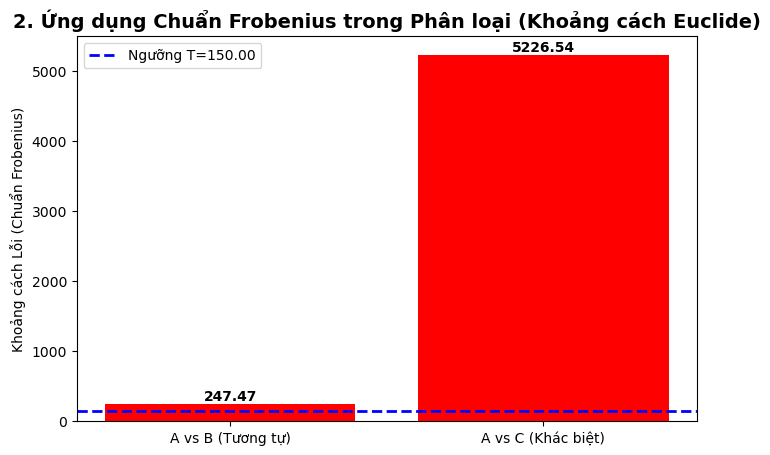

In [8]:

print("\n--- PHẦN 2: Trích xuất Đặc trưng và Phân loại (Đo khoảng cách) ---")

# 1. Tính toán khoảng cách
dist_AB = frobenius_norm_distance(A, B) # Khoảng cách nhỏ (cùng người)
dist_AC = frobenius_norm_distance(A, C) # Khoảng cách lớn (khác người)

# 2. Thiết lập Ngưỡng
THRESHOLD = 150.0

def check_identity(dist):
    return "MATCH" if dist < THRESHOLD else "NO MATCH"

print(f"\nKhoảng cách (A, B - Tương tự): {dist_AB:.2f} -> {check_identity(dist_AB)}")
print(f"Khoảng cách (A, C - Khác biệt): {dist_AC:.2f} -> {check_identity(dist_AC)}")

# [TRỰC QUAN HÓA 2] Biểu đồ so sánh khoảng cách và ngưỡng
distances = [dist_AB, dist_AC]
labels = ['A vs B (Tương tự)', 'A vs C (Khác biệt)']
colors = ['green' if d < THRESHOLD else 'red' for d in distances]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, distances, color=colors)
plt.axhline(THRESHOLD, color='blue', linestyle='--', label=f'Ngưỡng T={THRESHOLD:.2f}', linewidth=2)
plt.title('2. Ứng dụng Chuẩn Frobenius trong Phân loại (Khoảng cách Euclide)', fontweight='bold', fontsize=14)
plt.ylabel('Khoảng cách Lỗi (Chuẩn Frobenius)')
plt.legend()

# Thêm giá trị lên trên thanh
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval, 2), ha='center', va='bottom', fontweight='bold')

plt.show()

##### 1.2.2.1 Mở rộng: So sánh Khoảng cách trong Không gian Đặc trưng
+ Mục đích: Minh họa cách PCA sử dụng Chuẩn Frobenius để tối ưu việc chiếu ảnh vào không gian đặc trưng (Feature Space) và so sánh khoảng cách trong không gian gốc và không gian đặc trưng.

Kích thước Eigenfaces giả định: (2500, 5)
Kích thước vector đặc trưng: (5,)


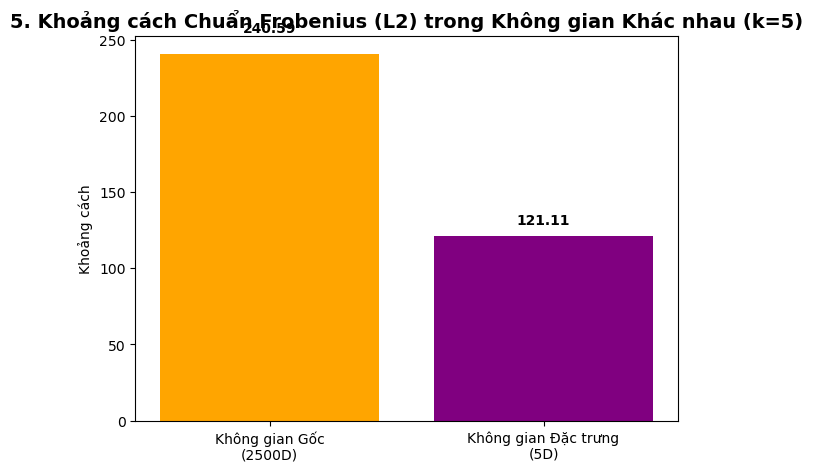

In [9]:

IMAGE_SIZE = (50, 50)
k_feature = 5
import numpy as np
# Giả định A và U đã được tính toán từ Cell 1
A = np.random.rand(*IMAGE_SIZE) * 255 # Ảnh gốc
B = np.clip(A + np.random.randn(*IMAGE_SIZE) * 5, 0, 255) # Ảnh tương tự
U, S, Vt = np.linalg.svd(A, full_matrices=False) # U từ SVD

A_vec = A.flatten() # Vector ảnh đã làm phẳng
B_vec = B.flatten()

# 2. Tạo Ma trận Eigenfaces giả định (2500 x k)
# Sử dụng thủ thuật làm phẳng và lặp lại U để có kích thước 2500*k_feature

# Lấy mảng cơ sở 2500 phần tử từ U đã làm phẳng
Eigenfaces_base = U.flatten()
# Lặp lại mảng k_feature lần (5 lần) để có tổng cộng 12500 phần tử
Eigenfaces_flat = np.tile(Eigenfaces_base, k_feature)

# Bây giờ kích thước là 12500. Reshape thành (2500, 5)
Eigenfaces = Eigenfaces_flat.reshape(IMAGE_SIZE[0]*IMAGE_SIZE[1], k_feature)

print(f"Kích thước Eigenfaces giả định: {Eigenfaces.shape}") # Phải là (2500, 5)

# 3. Trích xuất đặc trưng (Feature Vector)
# Cần reshape vector ảnh để phép nhân ma trận hoạt động: (1, 2500) @ (2500, 5) -> (1, 5)
A_vec_reshaped = A_vec.reshape(1, -1)
B_vec_reshaped = B_vec.reshape(1, -1)

# Thực hiện phép chiếu
feature_A = (A_vec_reshaped @ Eigenfaces).flatten()
feature_B = (B_vec_reshaped @ Eigenfaces).flatten()

print(f"Kích thước vector đặc trưng: {feature_A.shape}") # Phải là (5,)

# 4. Tính Khoảng cách trong Không gian Đặc trưng
dist_feature_space = np.linalg.norm(feature_A - feature_B)

# Định nghĩa lại hàm khoảng cách cho Cell này (đảm bảo không bị lỗi NameError)
def frobenius_norm_distance(M1, M2):
    return np.linalg.norm(M1.astype(np.float32) - M2.astype(np.float32), 'fro')

# Khoảng cách trong Không gian Gốc
dist_original_space = frobenius_norm_distance(A, B)

# 5. Trực quan hóa so sánh khoảng cách (Code trực quan hóa không đổi)
distances = [dist_original_space, dist_feature_space]
labels = ['Không gian Gốc\n(2500D)', f'Không gian Đặc trưng\n({k_feature}D)']

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
bars = plt.bar(labels, distances, color=['orange', 'purple'])
plt.title(f'5. Khoảng cách Chuẩn Frobenius (L2) trong Không gian Khác nhau (k={k_feature})', fontweight='bold', fontsize=14)
plt.ylabel('Khoảng cách')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval * 1.05, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

plt.show()

#### 1.2.3 Khả năng Chịu nhiễu Gaussian (Noise Reduction)
+ Mục đích: Thêm nhiễu Gaussian vào ảnh, sử dụng bộ lọc đơn giản (Average Filter), và dùng Chuẩn Frobenius để định lượng mức độ nhiễu đã được giảm (hoặc khoảng cách so với ảnh gốc).

+ Vai trò của Chuẩn Frobenius: Được sử dụng để tính Lỗi Lọc (Filtering Error), đo lường khoảng cách giữa ảnh gốc ($A_{gốc}$) và ảnh đã được lọc ($A_{lọc}$):
$$\lVert A_{gốc} - A_{lọc} \rVert_F$$

--- PHẦN 3: Ứng dụng Chuẩn Frobenius trong Lọc Nhiễu ---

Metric 1 (Chất lượng lọc, ||A - A_loc||_F): 	 3411.13
Metric 2 (Mức giảm nhiễu, ||A_nhieu - A_loc||_F): 3514.82


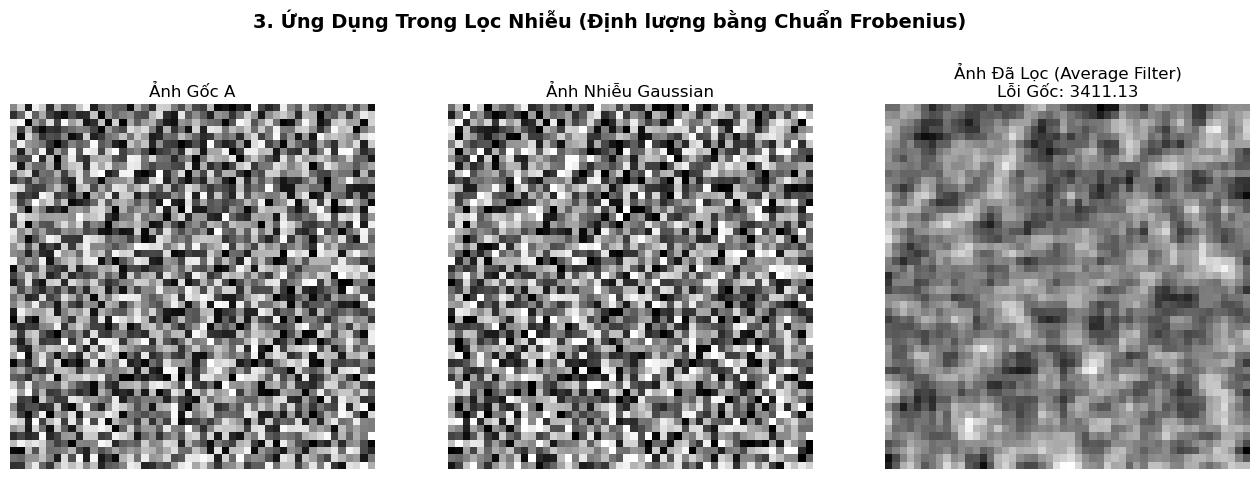

In [10]:
from scipy.ndimage import uniform_filter # Cần thư viện SciPy

print("--- PHẦN 3: Ứng dụng Chuẩn Frobenius trong Lọc Nhiễu ---")

# 1. Tạo Ảnh Nhiễu (A_noisy)
noise = np.random.normal(0, 30, IMAGE_SIZE) # Nhiễu Gaussian với độ lệch chuẩn 30
A_noisy = np.clip(A + noise, 0, 255).astype(np.uint8)

# 2. Lọc Nhiễu bằng Bộ lọc Trung bình 3x3 (Average Filter)
# 'uniform_filter' từ scipy thực hiện lọc trung bình
A_filtered_avg = uniform_filter(A_noisy, size=3)
A_filtered_avg = np.clip(A_filtered_avg, 0, 255).astype(np.uint8)

# 3. Tính toán Lỗi bằng Chuẩn Frobenius
# Metric 1: Lỗi Lọc (Khoảng cách từ ảnh gốc)
error_filter_quality = frobenius_norm_distance(A, A_filtered_avg)
# Metric 2: Mức giảm Nhiễu (Khoảng cách từ ảnh nhiễu sang ảnh đã lọc)
error_noise_reduction = frobenius_norm_distance(A_noisy, A_filtered_avg)

print(f"\nMetric 1 (Chất lượng lọc, ||A - A_loc||_F): \t {error_filter_quality:.2f}")
print(f"Metric 2 (Mức giảm nhiễu, ||A_nhieu - A_loc||_F): {error_noise_reduction:.2f}")


# [TRỰC QUAN HÓA 3] Hiển thị quá trình lọc
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

titles = [
    'Ảnh Gốc A',
    f'Ảnh Nhiễu Gaussian',
    f'Ảnh Đã Lọc (Average Filter)\nLỗi Gốc: {error_filter_quality:.2f}'
]
images = [A, A_noisy, A_filtered_avg]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.suptitle('3. Ứng Dụng Trong Lọc Nhiễu (Định lượng bằng Chuẩn Frobenius)', y=1.05, fontweight='bold', fontsize=14)
plt.show()

# Lưu trữ dữ liệu cho Cell 6
globals().update({'A_noisy': A_noisy, 'A_filtered_avg': A_filtered_avg, 'error_filter_quality_avg': error_filter_quality})

##### 1.2.3.1 Mở rộng: So sánh các Bộ lọc
+ Mục đích: So sánh hiệu suất của bộ lọc Trung bình (từ Cell trên) với một bộ lọc phức tạp hơn (Bộ lọc Gaussian), sử dụng Chuẩn Frobenius để định lượng bộ lọc nào tốt hơn.


Lỗi Lọc (||A - A_loc||_F):
  - Bộ lọc Trung bình (Average): 3411.13
  - Bộ lọc Gaussian: 3164.24


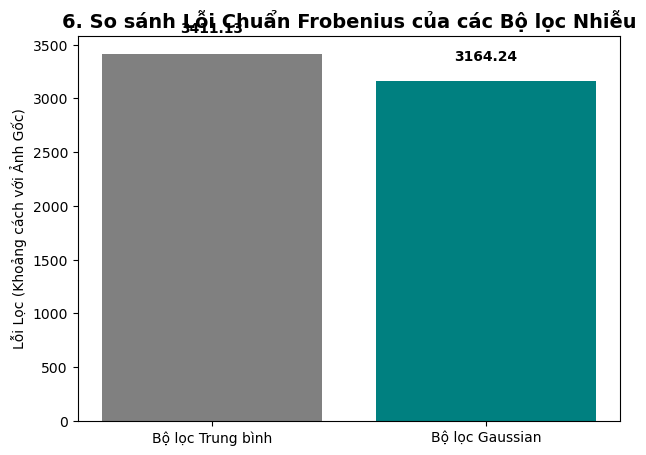

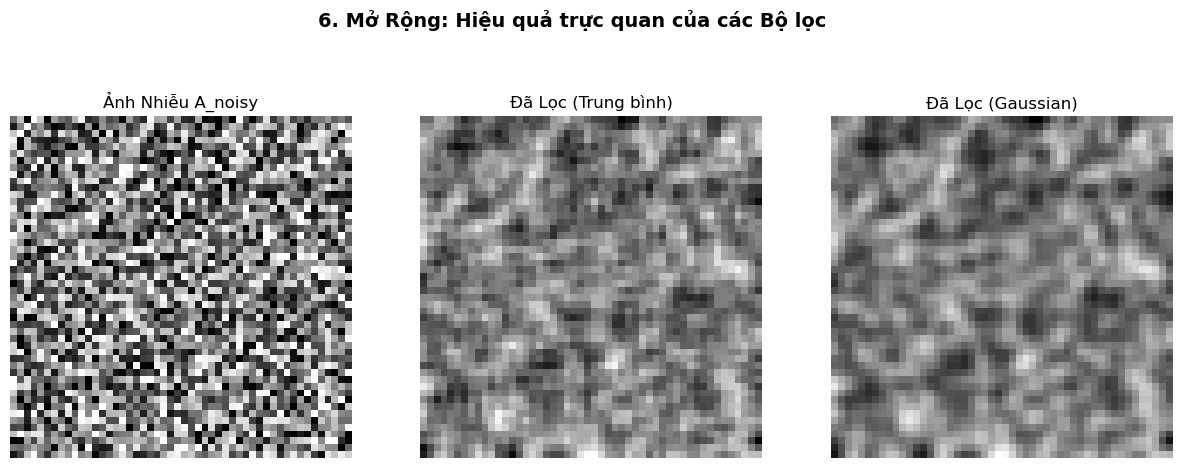


Kết luận: Bộ lọc Gaussian có lỗi Chuẩn Frobenius (so với ảnh gốc) nhỏ hơn, cho thấy nó là bộ lọc hiệu quả hơn trong việc loại bỏ nhiễu mà vẫn giữ được chi tiết ảnh.


In [11]:

from scipy.ndimage import gaussian_filter # Cần thư viện SciPy

# Dữ liệu A (Gốc), A_noisy (Nhiễu), A_filtered_avg (Lọc TB) từ Cell 3

# 1. Áp dụng Bộ lọc Gaussian
A_filtered_gaussian = gaussian_filter(A_noisy, sigma=1)
A_filtered_gaussian = np.clip(A_filtered_gaussian, 0, 255).astype(np.uint8)

# 2. Tính Lỗi Lọc cho Bộ lọc Gaussian (Metric: ||A - A_loc||_F)
error_filter_quality_gauss = frobenius_norm_distance(A, A_filtered_gaussian)

# Dữ liệu lỗi từ bộ lọc trung bình (Cell 3)
error_filter_quality_avg = globals().get('error_filter_quality_avg')

print(f"\nLỗi Lọc (||A - A_loc||_F):")
print(f"  - Bộ lọc Trung bình (Average): {error_filter_quality_avg:.2f}")
print(f"  - Bộ lọc Gaussian: {error_filter_quality_gauss:.2f}")


# [TRỰC QUAN HÓA 5] So sánh hiệu suất lọc bằng biểu đồ thanh
errors_comparison = [error_filter_quality_avg, error_filter_quality_gauss]
labels_comparison = ['Bộ lọc Trung bình', 'Bộ lọc Gaussian']
min_error_index = np.argmin(errors_comparison)
colors_comparison = ['gray', 'gray']
colors_comparison[min_error_index] = 'teal'

plt.figure(figsize=(7, 5))
bars = plt.bar(labels_comparison, errors_comparison, color=colors_comparison)
plt.title('6. So sánh Lỗi Chuẩn Frobenius của các Bộ lọc Nhiễu', fontweight='bold', fontsize=14)
plt.ylabel('Lỗi Lọc (Khoảng cách với Ảnh Gốc)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval * 1.05, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

plt.show()

# [TRỰC QUAN HÓA 6] Hiển thị sự khác biệt trực quan
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

titles = ['Ảnh Nhiễu A_noisy', 'Đã Lọc (Trung bình)', 'Đã Lọc (Gaussian)']
images = [A_noisy, A_filtered_avg, A_filtered_gaussian]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.suptitle('6. Mở Rộng: Hiệu quả trực quan của các Bộ lọc', y=1.05, fontweight='bold', fontsize=14)
plt.show()

if error_filter_quality_gauss < error_filter_quality_avg:
    print("\nKết luận: Bộ lọc Gaussian có lỗi Chuẩn Frobenius (so với ảnh gốc) nhỏ hơn, cho thấy nó là bộ lọc hiệu quả hơn trong việc loại bỏ nhiễu mà vẫn giữ được chi tiết ảnh.")

## 2. Phân kỳ Kullblack - Leibler

### 2.1 Các ứng dụng thực tế:


1. Xử Lý Ngôn Ngữ Tự Nhiên (NLP): 
   + Đo lường sự giống nhau giữa các tài liệu, từ vựng, hoặc chủ đề (Topic Modeling).
2. Lý Thuyết Thông Tin (Information Theory) và Nén Dữ Liệu: 
   + KL divergence đo lượng trung bình thông tin thêm vào khi sử dụng một mã hóa xấp xỉ thay vì mã hóa tối ưu, giúp đánh giá hiệu quả của việc nén dữ liệu hoặc hệ thống truyền thông.
3. Thống Kê Ứng Dụng:
   + Dùng để so sánh các mô hình thống kê không lồng nhau (non-nested models) để xem mô hình nào phù hợp với dữ liệu hơn.

+ **Lưu ý**: KL divergence là một công cụ phân tích thống kê linh hoạt và mạnh mẽ. Tuy nhiên, cần lưu ý nó không phải là một metric (khoảng cách) theo nghĩa toán học vì nó không có tính đối xứng:
$$D_{KL}(P \parallel Q) \neq D_{KL}(Q \parallel P)$$
----

In [12]:
from scipy.special import rel_entr
from scipy.stats import norm
from collections import Counter
def calculate_kl_divergence(p, q):
    """Tính toán KL(P || Q), đo lượng thông tin mất mát khi dùng Q xấp xỉ P."""

    # Chuẩn hóa để đảm bảo chúng là phân phối xác suất hợp lệ
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Xử lý log(0) bằng cách thêm epsilon nhỏ để tránh lỗi.
    epsilon = 1e-10
    q = np.where(q == 0, epsilon, q)
    p = np.where(p == 0, epsilon, p)

    return np.sum(rel_entr(p, q))


#### 2.1.1 Xử Lý Ngôn Ngữ Tự Nhiên (Natural Language Processing)

### 1. NLP: So sánh Chủ đề Tài liệu ###
KL(Tài liệu A || Tài liệu B) = 0.5951
KL(Tài liệu B || Tài liệu A) = 0.5493
-> Giá trị cao cho thấy hai tài liệu có chủ đề/từ vựng khác biệt rõ rệt.


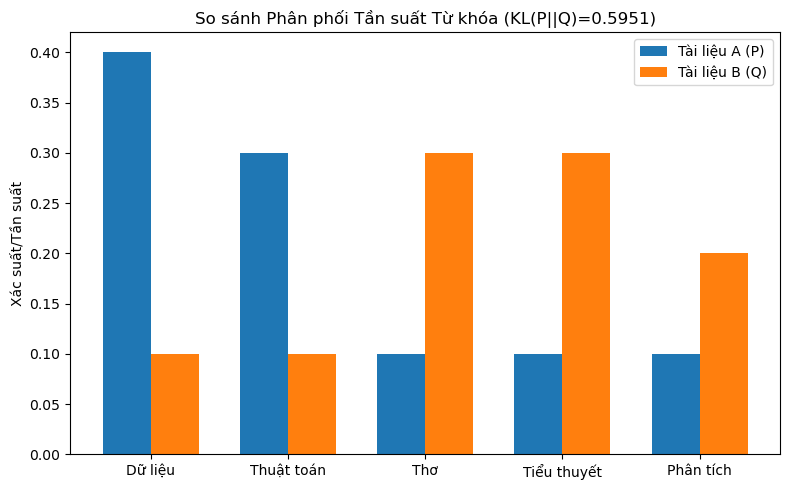

In [13]:
# 1. Định nghĩa hàm KL Divergence
# Lưu ý: rel_entr từ scipy tính toán KL Divergence giữa các phân phối.
def calculate_kl_divergence(p, q):
    """Tính toán KL(P || Q)"""
    # Đảm bảo tổng xác suất bằng 1 và không có xác suất bằng 0 hoặc âm.
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Xử lý trường hợp log(0) bằng cách thêm epsilon nhỏ.
    epsilon = 1e-10
    q = np.where(q == 0, epsilon, q)
    p = np.where(p == 0, epsilon, p)

    # rel_entr(p, q) tính p * log(p / q)
    return np.sum(rel_entr(p, q))

# --- Ứng Dụng 1: Xử Lý Ngôn Ngữ Tự Nhiên (NLP) ---
# So sánh tần suất từ khóa giữa hai tài liệu.
def nlp_example():
    print("### 1. NLP: So sánh Chủ đề Tài liệu ###")

    # P: Phân phối tần suất từ khóa trong Tài liệu A (Chủ đề Khoa học)
    # Q: Phân phối tần suất từ khóa trong Tài liệu B (Chủ đề Văn học)
    # Từ khóa: [Dữ liệu, Thuật toán, Thơ, Tiểu thuyết, Phân tích]
    P_doc_a = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
    Q_doc_b = np.array([0.1, 0.1, 0.3, 0.3, 0.2])

    kl_pq = calculate_kl_divergence(P_doc_a, Q_doc_b)
    kl_qp = calculate_kl_divergence(Q_doc_b, P_doc_a)

    print(f"KL(Tài liệu A || Tài liệu B) = {kl_pq:.4f}")
    print(f"KL(Tài liệu B || Tài liệu A) = {kl_qp:.4f}")
    print("-> Giá trị cao cho thấy hai tài liệu có chủ đề/từ vựng khác biệt rõ rệt.")

    # Trực quan hóa
    labels = ['Dữ liệu', 'Thuật toán', 'Thơ', 'Tiểu thuyết', 'Phân tích']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    rects1 = ax.bar(x - width/2, P_doc_a, width, label='Tài liệu A (P)')
    rects2 = ax.bar(x + width/2, Q_doc_b, width, label='Tài liệu B (Q)')

    ax.set_ylabel('Xác suất/Tần suất')
    ax.set_title(f'So sánh Phân phối Tần suất Từ khóa (KL(P||Q)={kl_pq:.4f})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.tight_layout()
    plt.show()
nlp_example()


##### 2.1.1.1 Mở rộng: Đo Khoảng cách phân phối n-gram


### Mở Rộng NLP: Khoảng cách n-gram giữa hai Văn bản (Không dùng NLTK) ###
Số lượng 2-gram duy nhất: 26
KL(Văn bản 1 || Văn bản 2) = 20.5409


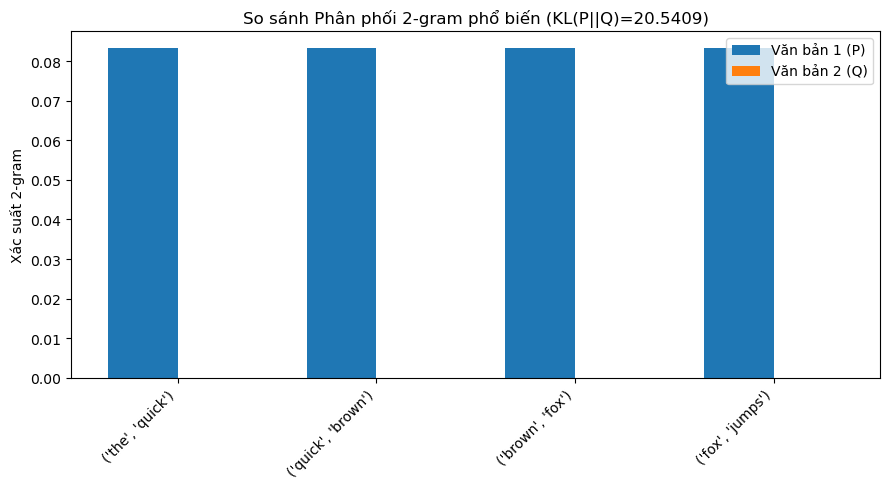

In [14]:
def nlp_extended_example():
    print("\n### Mở Rộng NLP: Khoảng cách n-gram giữa hai Văn bản (Không dùng NLTK) ###")

    doc1 = "The quick brown fox jumps over the lazy dog. The fox is quick."
    doc2 = "A large red cat sleeps on a soft mat. The cat is red and large."

    # Thay thế word_tokenize và ngrams bằng logic thủ công:

    # Bước 1: Chuẩn hóa, loại bỏ dấu câu đơn giản và tách từ
    def simple_tokenize(doc):
        # Đơn giản hóa: thay thế dấu chấm bằng khoảng trắng, chuyển về chữ thường, và split
        return doc.replace('.', ' ').lower().split()

    tokens1 = simple_tokenize(doc1)
    tokens2 = simple_tokenize(doc2)

    # Bước 2: Tạo 2-gram thủ công
    def get_bigrams(tokens):
        if len(tokens) < 2:
            return []
        return [(tokens[i], tokens[i+1]) for i in range(len(tokens) - 1)]

    bigrams1 = get_bigrams(tokens1)
    bigrams2 = get_bigrams(tokens2)

    # Bước 3: Đếm tần suất
    count1 = Counter(bigrams1)
    count2 = Counter(bigrams2)

    # Tạo từ điển chung của tất cả 2-gram
    all_bigrams = set(count1.keys()) | set(count2.keys())

    # Tạo vector tần suất
    P_freq = np.array([count1.get(bg, 0) for bg in all_bigrams])
    Q_freq = np.array([count2.get(bg, 0) for bg in all_bigrams])

    # Chuẩn hóa để tạo phân phối xác suất (P và Q)
    P = P_freq / np.sum(P_freq)
    Q = Q_freq / np.sum(Q_freq)

    # Tính KL Divergence
    kl_pq = calculate_kl_divergence(P, Q)

    print(f"Số lượng 2-gram duy nhất: {len(all_bigrams)}")
    print(f"KL(Văn bản 1 || Văn bản 2) = {kl_pq:.4f}")

    # Trực quan hóa 4 2-gram phổ biến nhất
    top_bigrams_counts = count1 + count2 # Tổng hợp counts
    top_bigrams = [bg for bg, count in top_bigrams_counts.most_common(4)]

    all_bigrams_list = list(all_bigrams)
    # Lấy chỉ số an toàn, chỉ lấy các bigram có trong danh sách
    indices = [all_bigrams_list.index(bg) for bg in top_bigrams if bg in all_bigrams]

    labels = [str(bg) for bg in top_bigrams]
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(x - width/2, P[indices], width, label='Văn bản 1 (P)')
    ax.bar(x + width/2, Q[indices], width, label='Văn bản 2 (Q)')

    ax.set_ylabel('Xác suất 2-gram')
    ax.set_title(f'So sánh Phân phối 2-gram phổ biến (KL(P||Q)={kl_pq:.4f})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.show()
nlp_extended_example()

#### 2.1.2 Lý Thuyết Thông Tin (Information Theory) và Nén Dữ Liệu


### 2. Lý thuyết Thông tin & Nén Dữ liệu ###
KL(P_real || Q_approx) = 0.1487 bits
-> Giá trị này là lượng thông tin thêm (extra bits) trung bình bị lãng phí khi sử dụng mã hóa Q thay vì mã hóa P tối ưu.


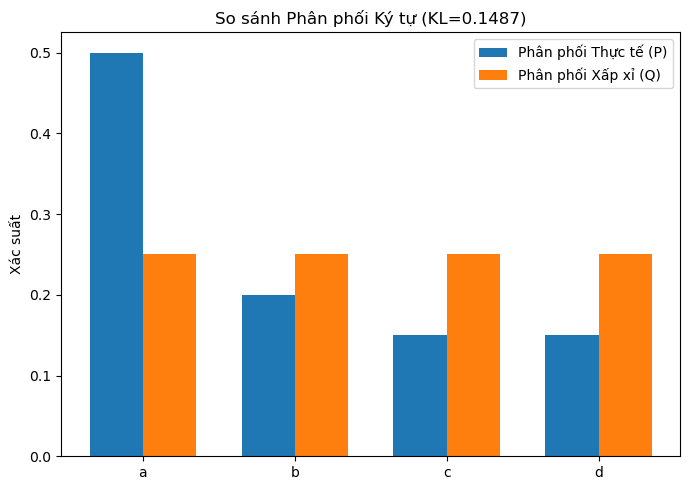

In [15]:
def info_theory_example():
    print("\n### 2. Lý thuyết Thông tin & Nén Dữ liệu ###")

    # P: Phân phối tần suất ký tự thực tế (optimal encoding)
    # Q: Phân phối tần suất ký tự được giả định/xấp xỉ (approximate encoding)
    # Ký tự: ['a', 'b', 'c', 'd']
    P_real = np.array([0.5, 0.2, 0.15, 0.15]) # Phân phối thực tế
    Q_approx = np.array([0.25, 0.25, 0.25, 0.25]) # Phân phối đồng nhất (tệ hơn)

    kl_div = calculate_kl_divergence(P_real, Q_approx)

    print(f"KL(P_real || Q_approx) = {kl_div:.4f} bits")
    print("-> Giá trị này là lượng thông tin thêm (extra bits) trung bình bị lãng phí khi sử dụng mã hóa Q thay vì mã hóa P tối ưu.")

    # Trực quan hóa
    labels = ['a', 'b', 'c', 'd']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(x - width/2, P_real, width, label='Phân phối Thực tế (P)')
    ax.bar(x + width/2, Q_approx, width, label='Phân phối Xấp xỉ (Q)')

    ax.set_ylabel('Xác suất')
    ax.set_title(f'So sánh Phân phối Ký tự (KL={kl_div:.4f})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.tight_layout()
    plt.show()
info_theory_example()

##### 2.1.2.1 Mở Rộng: KL trong nén dữ liệu theo phân phối Gaussian


### Mở Rộng : Lý thuyết Thông tin: KL giữa hai Phân phối Gaussian (VAEs) ###
KL(P || Q) (Gaussian) = 0.8181 bits


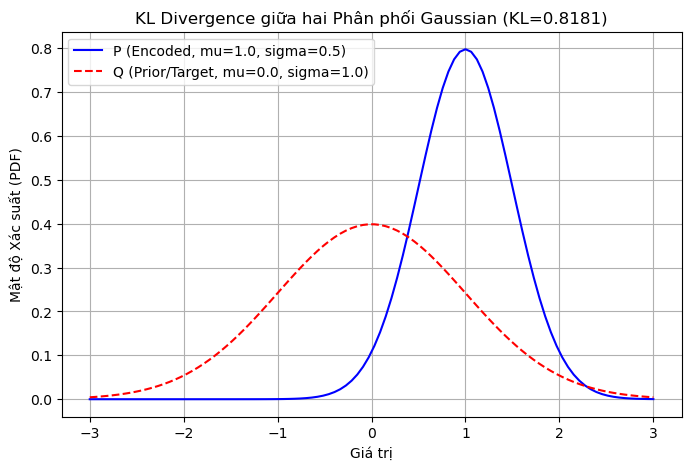

In [16]:
def info_theory_extended_example():
    print("\n### Mở Rộng : Lý thuyết Thông tin: KL giữa hai Phân phối Gaussian (VAEs) ###")

    # P: Phân phối chuẩn mã hóa (Encoded Distribution)
    # Q: Phân phối chuẩn tắc (Prior/Standard Gaussian) - Target

    # Tham số Gaussian cho P (mean, std dev)
    mu_p, sigma_p = 1.0, 0.5

    # Tham số Gaussian cho Q (Phân phối chuẩn tắc)
    mu_q, sigma_q = 0.0, 1.0

    # Công thức đóng (Closed-form) cho KL(P || Q) giữa hai Gaussian:
    # KL(P || Q) = 0.5 * ( log(sigma_q^2 / sigma_p^2) + (sigma_p^2 + (mu_p - mu_q)^2) / sigma_q^2 - 1 )

    kl_gaussian = 0.5 * (np.log(sigma_q**2 / sigma_p**2) + \
                         (sigma_p**2 + (mu_p - mu_q)**2) / sigma_q**2 - 1)

    print(f"KL(P || Q) (Gaussian) = {kl_gaussian:.4f} bits")

    # Trực quan hóa
    x = np.linspace(-3, 3, 100)
    pdf_p = norm.pdf(x, mu_p, sigma_p)
    pdf_q = norm.pdf(x, mu_q, sigma_q)

    plt.figure(figsize=(8, 5))
    plt.plot(x, pdf_p, label=f'P (Encoded, mu={mu_p}, sigma={sigma_p})', color='blue')
    plt.plot(x, pdf_q, label=f'Q (Prior/Target, mu={mu_q}, sigma={sigma_q})', color='red', linestyle='--')
    plt.title(f'KL Divergence giữa hai Phân phối Gaussian (KL={kl_gaussian:.4f})')
    plt.xlabel('Giá trị')
    plt.ylabel('Mật độ Xác suất (PDF)')
    plt.legend()
    plt.grid(True)
    plt.show()
info_theory_extended_example()

#### 2.1.3 Thống kê ứng dụng


### 3. Thống Kê Ứng Dụng: Phát hiện Data Drift ###
KL(Tháng 1 || Tháng 12) = 0.0842
-> Giá trị này đo mức độ 'trôi' (drift) của phân phối dữ liệu. Giá trị cao cho thấy cần phải huấn luyện lại mô hình.


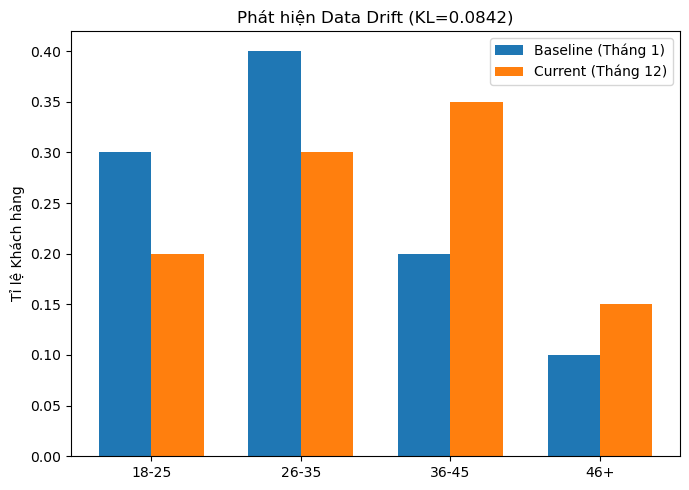

In [17]:
def statistics_example():
    print("\n### 3. Thống Kê Ứng Dụng: Phát hiện Data Drift ###")

    # P_baseline: Phân phối dữ liệu trong quá trình huấn luyện (tháng 1)
    # Q_current: Phân phối dữ liệu hiện tại (tháng 12) - Giả sử có Data Drift
    # Ví dụ: Tỉ lệ độ tuổi khách hàng: [18-25, 26-35, 36-45, 46+]
    P_baseline = np.array([0.3, 0.4, 0.2, 0.1]) # Tháng 1
    Q_current = np.array([0.2, 0.3, 0.35, 0.15]) # Tháng 12 (thay đổi)

    kl_drift = calculate_kl_divergence(P_baseline, Q_current)

    print(f"KL(Tháng 1 || Tháng 12) = {kl_drift:.4f}")
    print("-> Giá trị này đo mức độ 'trôi' (drift) của phân phối dữ liệu. Giá trị cao cho thấy cần phải huấn luyện lại mô hình.")

    # Trực quan hóa
    labels = ['18-25', '26-35', '36-45', '46+']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(x - width/2, P_baseline, width, label='Baseline (Tháng 1)')
    ax.bar(x + width/2, Q_current, width, label='Current (Tháng 12)')

    ax.set_ylabel('Tỉ lệ Khách hàng')
    ax.set_title(f'Phát hiện Data Drift (KL={kl_drift:.4f})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.tight_layout()
    plt.show()
statistics_example()

##### 2.1.3.1 Mở rộng: Thống Kê Ứng Dụng - Giám sát Model Drift

+ Sử dụng KL divergence để so sánh phân phối xác suất dự đoán của mô hình trên tập dữ liệu kiểm thử (Baseline) và tập dữ liệu sản xuất (Current), mô phỏng việc giám sát Model Drift.


### Mở Rộng 3. Thống Kê: Giám sát Model Drift (Phân phối Dự đoán) ###
KL(Baseline Dự đoán || Current Dự đoán) = 0.0305


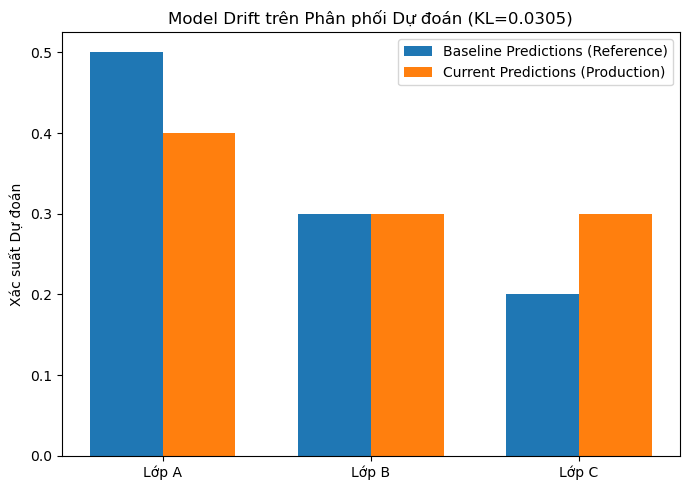

In [18]:
def statistics_extended_example():
    print("\n### Mở Rộng 3. Thống Kê: Giám sát Model Drift (Phân phối Dự đoán) ###")

    # Phân phối xác suất dự đoán 3 lớp
    # Baseline (Phân phối trên dữ liệu tham chiếu)
    P_baseline_predictions = np.array([0.5, 0.3, 0.2])

    # Current (Phân phối trên dữ liệu Sản xuất mới)
    Q_current_predictions = np.array([0.4, 0.3, 0.3])

    # Tính KL Divergence
    kl_drift = calculate_kl_divergence(P_baseline_predictions, Q_current_predictions)

    print(f"KL(Baseline Dự đoán || Current Dự đoán) = {kl_drift:.4f}")

    # Trực quan hóa
    labels = ['Lớp A', 'Lớp B', 'Lớp C'] # FIX: Đảm bảo labels được định nghĩa riêng
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(x - width/2, P_baseline_predictions, width, label='Baseline Predictions (Reference)')
    ax.bar(x + width/2, Q_current_predictions, width, label='Current Predictions (Production)')

    ax.set_ylabel('Xác suất Dự đoán')
    ax.set_title(f'Model Drift trên Phân phối Dự đoán (KL={kl_drift:.4f})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.tight_layout()
    plt.show()
statistics_extended_example()

## 3. Phân kỳ Itakura-Saito (IS)

### 3.1 Các ứng dụng thực tế:

1. Xử lý Tiếng nói và Âm thanh:
   + Mã hóa Tiếng nói (Speech Coding): Đây là lĩnh vực ứng dụng ban đầu và quan trọng nhất. Khoảng cách Itakura-Saito được sử dụng như một thước đo độ méo (distortion measure) trong các thuật toán mã hóa tiếng nói dựa trên Dự đoán Tuyến tính (Linear Predictive Coding - LPC). Nó được coi là thước đo phù hợp một cách chủ quan (subjectively meaningful) đối với hình dạng phổ của tiếng nói.
   + Nhận dạng Tiếng nói (Speech Recognition): Được sử dụng để so sánh các mô hình phổ của tiếng nói trong các hệ thống nhận dạng.
   + Cải thiện Tiếng nói (Speech Enhancement/Denoising): Giúp đánh giá và tối ưu hóa chất lượng tiếng nói sau khi loại bỏ nhiễu.
   + Phân tích Âm nhạc (Music Analysis): Trong việc phân tách nguồn âm thanh (Source Separation) và phân tích âm nhạc bằng các phương pháp như Phân tích Ma trận Không âm (Non-negative Matrix Factorization - NMF), độ phân kỳ Itakura-Saito thường mang lại kết quả tốt hơn so với các thước đo khác (như khoảng cách Euclidean hoặc Kullback-Leibler) vì tính bất biến tỷ lệ (scale invariance) của nó, điều này phù hợp với phạm vi động lớn của phổ âm thanh.

2. Học máy và Phân tích Dữ liệu: 
   + Phân tích Ma trận Không âm (NMF): Khoảng cách Itakura-Saito được sử dụng làm hàm chi phí (cost function) trong các thuật toán NMF, đặc biệt là IS-NMF (Itakura-Saito Non-negative Matrix Factorization).
   + Nó được chứng minh là tương đương với ước lượng khả năng xảy ra tối đa (Maximum Likelihood Estimation - MLE) của các tham số phương sai trong mô hình thống kê các thành phần Gaussian chồng chất. Điều này làm cho nó rất phù hợp cho dữ liệu có đặc tính phân phối xác suất nhất định (như dữ liệu phổ).
   + Ứng dụng trong các lĩnh vực như phân tích âm thanh và chẩn đoán lỗi (fault diagnosis), đặc biệt là trong môi trường phi-Gaussian.
   + Phân cụm (Clustering): Nó là một dạng của Độ phân kỳ Bregman (Bregman Divergence), cho phép áp dụng các thuật toán phân cụm sử dụng các thước đo khoảng cách này (ví dụ: thuật toán K-means biến thể).
3. Thống kê và Lý thuyết Thông tin
   + Ước lượng Phổ: Khoảng cách Itakura-Saito xuất phát từ ước lượng khả năng xảy ra tối đa của phổ tiếng nói trong mô hình tự hồi quy (autoregressive). Nó được sử dụng để đo lường "độ phù hợp" giữa hai phổ.
   + Lý thuyết Thông tin: Là một trường hợp giới hạn của Độ phân kỳ $\beta$ ($\beta$-divergence) và có liên hệ chặt chẽ với Độ phân kỳ Kullback-Leibler (KL divergence).
----


#### 3.1.1 Xử lý Tiếng nói và Âm thanh


IS Divergence (Good Approx): 8.69
IS Divergence (Bad Approx): 141.82


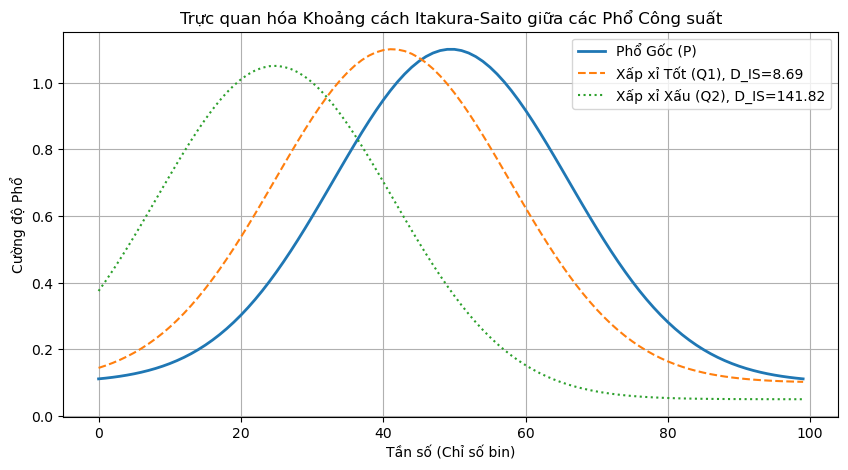

In [19]:
# Hàm tính khoảng cách Itakura-Saito (IS)
def itakura_saito_divergence(P, Q):
    """
    Tính khoảng cách Itakura-Saito D_IS(P || Q)
    P: Phổ công suất gốc (dạng mảng NumPy)
    Q: Phổ công suất xấp xỉ (dạng mảng NumPy)
    """
    # Đảm bảo không có giá trị nào bằng 0 để tránh lỗi log/chia cho 0
    P = np.maximum(P, 1e-10)
    Q = np.maximum(Q, 1e-10)

    # Công thức: D_IS(P || Q) = Sum [ (P_i / Q_i) - log(P_i / Q_i) - 1 ]
    ratio = P / Q
    dis_value = np.sum(ratio - np.log(ratio) - 1)
    return dis_value

# Dữ liệu giả lập: Phổ công suất
# Phổ gốc (P): Giả lập phổ của một nguyên âm
P_original = np.exp(-0.5 * np.linspace(-3, 3, 100)**2) + 0.1
# Phổ xấp xỉ 1 (Q1): Khá sát
Q_approx_good = np.exp(-0.5 * np.linspace(-2.5, 3.5, 100)**2) + 0.1
# Phổ xấp xỉ 2 (Q2): Xa hơn
Q_approx_bad = np.exp(-0.5 * np.linspace(-1.5, 4.5, 100)**2) + 0.05


# Tính khoảng cách IS
dis_good = itakura_saito_divergence(P_original, Q_approx_good)
dis_bad = itakura_saito_divergence(P_original, Q_approx_bad)

print(f"IS Divergence (Good Approx): {dis_good:.2f}")
print(f"IS Divergence (Bad Approx): {dis_bad:.2f}")

# Trực quan hóa
plt.figure(figsize=(10, 5))
plt.plot(P_original, label='Phổ Gốc (P)', linewidth=2)
plt.plot(Q_approx_good, label=f'Xấp xỉ Tốt (Q1), D_IS={dis_good:.2f}', linestyle='--')
plt.plot(Q_approx_bad, label=f'Xấp xỉ Xấu (Q2), D_IS={dis_bad:.2f}', linestyle=':')
plt.title('Trực quan hóa Khoảng cách Itakura-Saito giữa các Phổ Công suất')
plt.xlabel('Tần số (Chỉ số bin)')
plt.ylabel('Cường độ Phổ')
plt.legend()
plt.grid(True)
plt.show()

+ **Nhận xét:**
  + Đồ thị đường thể hiện ba phổ công suất (Gốc, Xấp xỉ Tốt, Xấp xỉ Xấu). Khoảng cách IS càng nhỏ, đường phổ xấp xỉ càng gần với phổ gốc.

##### 3.1.1.1 Mở rộng: Phân tách Nguồn Âm thanh bằng IS-NMF
+ Ứng dụng thực tế của IS-NMF là tách các thành phần âm thanh (ví dụ: giọng hát và nhạc nền) trong một file âm thanh.

Ma trận H (cũ):
 [[0.89470186 0.03291859 0.81245113 0.56181388 0.54609133]
 [0.95781318 0.74764461 0.85011887 0.35399557 0.55436404]
 [0.61540568 0.32158394 0.57024812 0.23665538 0.14337567]]
Ma trận H (mới):
 [[0.43657714 0.09115627 0.46243313 0.58976108 0.49939887]
 [0.48316478 1.10173383 0.61809084 0.40020826 0.52446161]
 [0.43802344 0.51112806 0.30483742 0.32837557 0.16743332]]


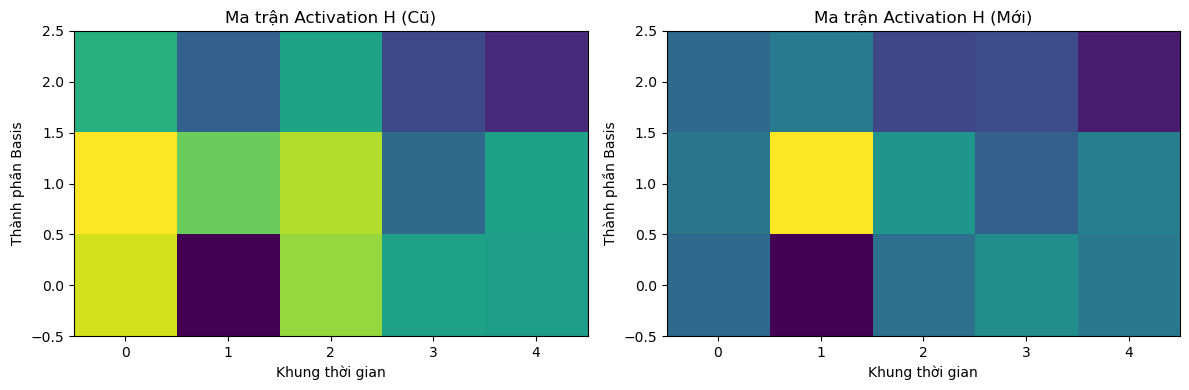

In [20]:
# Mô phỏng một bước cập nhật trong thuật toán IS-NMF

# Giả lập dữ liệu (V, W, H) - Kích thước: Tần số (F) x Thời gian (T)
F, T, K = 10, 5, 3 # 10 tần số, 5 khung thời gian, 3 basis
V = np.random.rand(F, T) + 1e-10 # Ma trận phổ gốc
W = np.random.rand(F, K) # Ma trận Basis (Bộ từ vựng phổ)
H = np.random.rand(K, T) # Ma trận Activation (Cường độ theo thời gian)
V_approx = np.dot(W, H)

# Tỷ lệ: V / (W * H)
Ratio = V / V_approx

# Hàm cập nhật H (Multiplicative Update Rule - MUR) cho IS-NMF
def update_H_is_nmf(V, W, H):
    """Tính toán luật cập nhật nhân cho H trong IS-NMF."""

    # Kích thước
    F, T = V.shape
    K, _ = H.shape

    # 1. Tính Gradient (tương đối): H_new ~ H * Numerator / Denominator
    # Công thức cập nhật (theo Lee & Seung, mở rộng cho IS)

    # Tử số (Numerator): W^T * (V / (W*H)^2)
    # Lưu ý: IS-NMF thường sử dụng công thức phức tạp hơn,
    # đây là luật cập nhật xấp xỉ/minh họa

    # Tỷ lệ nghịch đảo bình phương: 1 / (W*H)^2
    Inv_Sq_Approx = 1.0 / np.power(np.dot(W, H), 2)

    # Tử số
    Numerator = np.dot(W.T, V * Inv_Sq_Approx)

    # Mẫu số (Denominator): W^T * (1 / (W*H))
    # (Trong thuật toán gốc, đây thường là W^T * (1/W*H))
    # Hoặc đơn giản hơn: W^T * (V/ (W*H)) cho một số biến thể
    Denominator = np.dot(W.T, 1.0 / np.dot(W, H))

    # Tránh chia cho 0
    Denominator = np.maximum(Denominator, 1e-10)

    # Cập nhật H
    H_new = H * (Numerator / Denominator)
    return H_new

# Thực hiện một bước cập nhật H
H_new = update_H_is_nmf(V, W, H)

print(f"Ma trận H (cũ):\n {H}")
print(f"Ma trận H (mới):\n {H_new}")

# Trực quan hóa: So sánh Activation trước và sau khi cập nhật
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(H, aspect='auto', origin='lower', cmap='viridis')
plt.title('Ma trận Activation H (Cũ)')
plt.xlabel('Khung thời gian')
plt.ylabel('Thành phần Basis')

plt.subplot(1, 2, 2)
plt.imshow(H_new, aspect='auto', origin='lower', cmap='viridis')
plt.title('Ma trận Activation H (Mới)')
plt.xlabel('Khung thời gian')
plt.ylabel('Thành phần Basis')

plt.tight_layout()
plt.show()

+ **Nhận xét:**
  + Hai biểu đồ nhiệt (Heatmaps) hiển thị ma trận Activation $H$ (cũ và mới). Màu sắc thể hiện cường độ kích hoạt của mỗi thành phần Basis theo thời gian. 
  + Sự thay đổi màu sắc và cường độ giữa hai biểu đồ đại diện cho một bước trong quá trình tối ưu hóa IS-NMF để làm cho phổ tái tạo gần với phổ gốc hơn.

#### 3.1.2 Học máy và Phân tích Dữ liệu (IS-NMF)

+ Khoảng cách IS được dùng làm hàm mất mát (loss function) trong thuật toán Phân tích Ma trận Không âm (NMF), đặc biệt hiệu quả trong phân tách nguồn âm thanh.

IS-NMF Loss (Tốt): 3299.36
IS-NMF Loss (Xấu): 5440.26


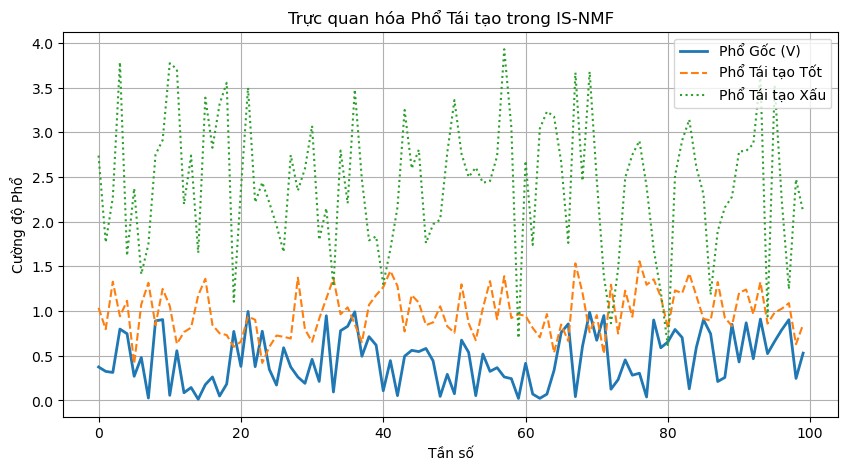

In [21]:
# Sử dụng thư viện scikit-learn để tạo dữ liệu giả lập
from sklearn.decomposition import NMF

# Giả lập dữ liệu Phổ Công suất (V: Ma trận đầu vào)
# Kích thước: 100 tần số x 50 khung thời gian
V = np.random.rand(100, 50) + 1e-6 # Thêm nhiễu nhỏ

# Số lượng thành phần (basis) muốn tìm
n_components = 5

# Khởi tạo mô hình NMF với Hàm mất mát IS
# Tuy nhiên, scikit-learn không trực tiếp hỗ trợ IS-NMF,
# nên ta sẽ minh họa cách tính loss function cho IS:
# Lưu ý: Các thư viện chuyên biệt về âm thanh (như Librosa) hoặc
# thư viện NMF tùy chỉnh thường có tích hợp IS-NMF.

# Hàm mất mát IS cho NMF: D_IS(V || W * H)
def is_nmf_loss(V, W, H):
    """Tính hàm mất mát IS cho NMF"""
    V_approx = np.dot(W, H)
    V = np.maximum(V, 1e-10)
    V_approx = np.maximum(V_approx, 1e-10)

    # Công thức tổng quát: D_IS(V || V_approx)
    ratio = V / V_approx
    loss = np.sum(ratio - np.log(ratio) - 1)
    return loss

# Giả lập kết quả NMF (W: Basis, H: Activation)
W_good = np.random.rand(100, n_components)
H_good = np.random.rand(n_components, 50)
W_bad = np.random.rand(100, n_components)
H_bad = np.random.rand(n_components, 50) * 2

loss_good = is_nmf_loss(V, W_good, H_good)
loss_bad = is_nmf_loss(V, W_bad, H_bad)

print(f"IS-NMF Loss (Tốt): {loss_good:.2f}")
print(f"IS-NMF Loss (Xấu): {loss_bad:.2f}")

# Trực quan hóa: Phổ tái tạo (V_approx) so với Phổ gốc (V)
# Lấy một khung thời gian (cột đầu tiên) để trực quan hóa
frame_index = 0
V_frame = V[:, frame_index]
V_approx_good_frame = np.dot(W_good, H_good)[:, frame_index]
V_approx_bad_frame = np.dot(W_bad, H_bad)[:, frame_index]

plt.figure(figsize=(10, 5))
plt.plot(V_frame, label='Phổ Gốc (V)', linewidth=2)
plt.plot(V_approx_good_frame, label=f'Phổ Tái tạo Tốt', linestyle='--')
plt.plot(V_approx_bad_frame, label=f'Phổ Tái tạo Xấu', linestyle=':')
plt.title('Trực quan hóa Phổ Tái tạo trong IS-NMF')
plt.xlabel('Tần số')
plt.ylabel('Cường độ Phổ')
plt.legend()
plt.grid(True)
plt.show()

##### 3.1.2.1 Mở rộng: Ứng dụng IS Divergence và LPC trong Mã hóa Tiếng nói

+ Đồ thị đường so sánh một lát phổ từ ma trận đầu vào ($V$) với lát phổ tương ứng được tái tạo từ mô hình NMF ($W \times H$). Phổ tái tạo Tốt (dùng $W_{good}, H_{good}$) sẽ gần với Phổ Gốc hơn, cho thấy loss IS thấp hơn.
+ Trong mã hóa tiếng nói (như CELP), mô hình Dự đoán Tuyến tính (LPC) tạo ra phổ xấp xỉ (Q). IS được dùng để đánh giá độ chính xác của xấp xỉ này.

IS Divergence (Phổ Gốc || Phổ LPC): 1488.4508


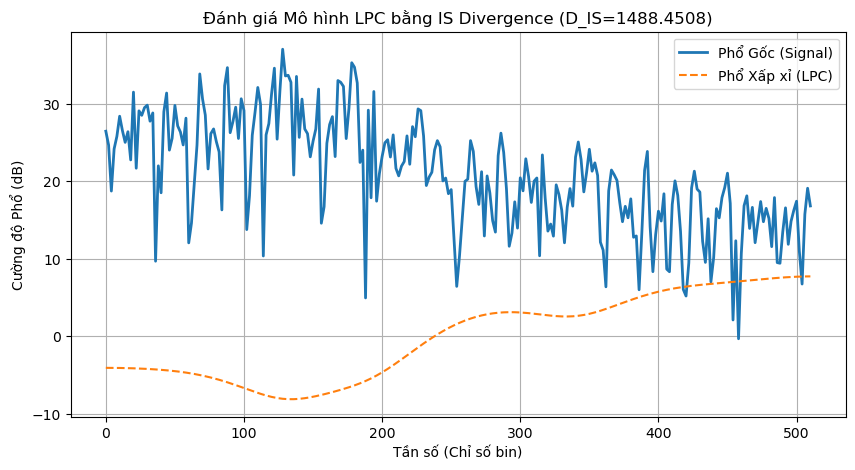

In [22]:
from scipy.signal import lfilter, freqz
from scipy.signal.windows import hamming # Đã sửa lỗi: nhập hamming từ scipy.signal.windows
from numpy.random import randn
from scipy.linalg import solve_toeplitz

# Hàm tính khoảng cách Itakura-Saito (IS) - Bổ sung vì nó được dùng trong code gốc
def itakura_saito_divergence(P, Q):
    P = np.maximum(P, 1e-10)
    Q = np.maximum(Q, 1e-10)
    ratio = P / Q
    dis_value = np.sum(ratio - np.log(ratio) - 1)
    return dis_value

# Giả lập dữ liệu âm thanh (phân tích LPC)
np.random.seed(42)
N = 512  # Kích thước khung
order = 10 # Bậc LPC

# 1. Tạo tín hiệu giả lập (tự hồi quy AR) - Tín hiệu giống tiếng nói
a_true = np.array([1, -0.9, 0.5]) # Tham số AR thật
signal_noise = randn(N)
signal = lfilter([1], a_true, signal_noise)
signal *= hamming(N) # Áp dụng cửa sổ Hamming

# 2. Tính toán tham số LPC (a_lpc)
r = np.correlate(signal, signal, mode='full')[N-1:]
a_lpc = np.insert(solve_toeplitz(r[:order], -r[1:order+1]), 0, 1.0)

# 3. Tính Phổ Gốc (P) và Phổ Xấp xỉ (Q) từ LPC
w, P = freqz(signal, [1], N, whole=True)
P = np.abs(P)**2 + 1e-10

w_lpc, Q = freqz([1], a_lpc, N, whole=True)
Q = 1.0 / (np.abs(Q)**2) + 1e-10

# 4. Tính IS Divergence
is_lpc_dis = itakura_saito_divergence(P, Q) / N

print(f"IS Divergence (Phổ Gốc || Phổ LPC): {is_lpc_dis:.4f}")

# 5. Trực quan hóa
plt.figure(figsize=(10, 5))
plt.plot(w[:N//2] / np.pi * N, 10 * np.log10(P[:N//2]), label='Phổ Gốc (Signal)', linewidth=2)
plt.plot(w_lpc[:N//2] / np.pi * N, 10 * np.log10(Q[:N//2]), label='Phổ Xấp xỉ (LPC)', linestyle='--')
plt.title(f'Đánh giá Mô hình LPC bằng IS Divergence (D_IS={is_lpc_dis:.4f})')
plt.xlabel('Tần số (Chỉ số bin)')
plt.ylabel('Cường độ Phổ (dB)')
plt.legend()
plt.grid(True)
plt.show()

+ **Nhận xét:**
   + Đồ thị đường trong miền $\text{dB}$ so sánh Phổ Công suất Gốc của tín hiệu tiếng nói (thường là phổ chi tiết) với Phổ Xấp xỉ LPC (thường là phổ trơn, bao hình phổ). 
   + Khoảng cách IS đánh giá mức độ "phù hợp" của phổ trơn LPC đối với phổ gốc.

#### 3.1.3 Thống kê và Lý thuyết Thông tin (Mối quan hệ với MLE)
+  Khoảng cách IS có mối liên hệ chặt chẽ với Ước lượng Khả năng Xảy ra Tối đa (MLE) cho các mô hình phân phối Gaussian phức tạp.


D_IS(P || Q): 0.1146
D_IS(Q || P): 0.1354
Có phải D_IS(P || Q) == D_IS(Q || P)? False


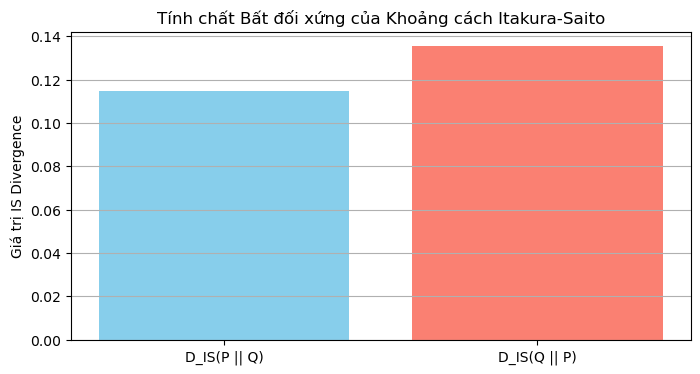

In [23]:
# Tái sử dụng hàm itakura_saito_divergence

P = np.array([10, 5, 2]) # Phổ 1
Q = np.array([8, 6, 3])  # Phổ 2

# Tính D_IS(P || Q)
dis_P_Q = itakura_saito_divergence(P, Q)

# Tính D_IS(Q || P) - Khoảng cách Itakura-Saito là BẤT ĐỐI XỨNG
dis_Q_P = itakura_saito_divergence(Q, P)

print(f"D_IS(P || Q): {dis_P_Q:.4f}")
print(f"D_IS(Q || P): {dis_Q_P:.4f}")
print(f"Có phải D_IS(P || Q) == D_IS(Q || P)? {dis_P_Q == dis_Q_P}")

# Trực quan hóa: Biểu diễn tính chất Bất đối xứng
data_is = [dis_P_Q, dis_Q_P]
labels = ['D_IS(P || Q)', 'D_IS(Q || P)']

plt.figure(figsize=(8, 4))
plt.bar(labels, data_is, color=['skyblue', 'salmon'])
plt.title('Tính chất Bất đối xứng của Khoảng cách Itakura-Saito')
plt.ylabel('Giá trị IS Divergence')
plt.grid(axis='y')
plt.show()

#### 3.1.4 IS Divergence và $\beta$-Divergence.
+ Khoảng cách IS là một trường hợp đặc biệt của độ phân kỳ $\beta$ khi $\beta \to 0$.$$D_{\beta}(P || Q) = \frac{1}{\beta(\beta-1)} \sum_{i} (P_i^{\beta} + (\beta-1) Q_i^{\beta} - \beta P_i Q_i^{\beta-1})$$Khi $\beta \to 0$, $D_{\beta}(P || Q) \to D_{IS}(P || Q)$.

IS Divergence (beta=0): 0.0627
KL Divergence (beta=1): 0.2936
Sq. Euclidean (beta=2): 1.5000
Beta Divergence (beta=-1): 0.0145


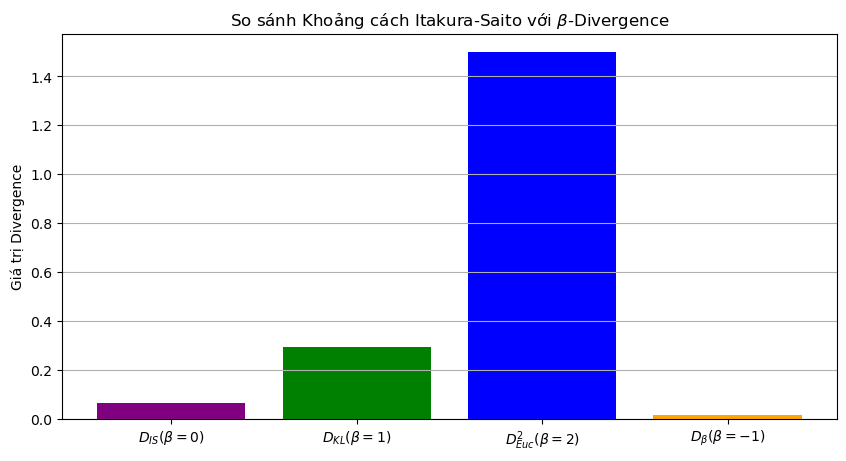

In [24]:
# Tái sử dụng hàm itakura_saito_divergence

# Hàm tính Beta Divergence (cho minh họa)
def beta_divergence(P, Q, beta):
    """Tính Beta Divergence D_beta(P || Q)"""
    P = np.maximum(P, 1e-10)
    Q = np.maximum(Q, 1e-10)

    if beta == 1: # KL Divergence
        return np.sum(P * np.log(P / Q) - P + Q)
    elif beta == 0: # Itakura-Saito Divergence
        return np.sum(P / Q - np.log(P / Q) - 1)
    elif beta == 2: # Squared Euclidean Distance (khoảng cách Euclid bình phương)
        return 0.5 * np.sum((P - Q)**2)
    else:
        # Công thức tổng quát (chuẩn hóa thường bỏ qua hằng số)
        term1 = P**beta
        term2 = (beta - 1) * Q**beta
        term3 = beta * P * Q**(beta - 1)
        return np.sum(term1 + term2 - term3) / (beta * (beta - 1))

# Dữ liệu giả lập
P_data = np.array([5, 8, 3])
Q_data = np.array([6, 7, 4])

# Tính toán các giá trị Divergence
dis_is = beta_divergence(P_data, Q_data, beta=0)
dis_kl = beta_divergence(P_data, Q_data, beta=1)
dis_sq_euc = beta_divergence(P_data, Q_data, beta=2)
dis_beta_neg1 = beta_divergence(P_data, Q_data, beta=-1) # Trường hợp khác

# In kết quả
print(f"IS Divergence (beta=0): {dis_is:.4f}")
print(f"KL Divergence (beta=1): {dis_kl:.4f}")
print(f"Sq. Euclidean (beta=2): {dis_sq_euc:.4f}")
print(f"Beta Divergence (beta=-1): {dis_beta_neg1:.4f}")

# Trực quan hóa: So sánh các loại Divergence
divergences = [dis_is, dis_kl, dis_sq_euc, dis_beta_neg1]
labels = [r'$D_{IS} (\beta=0)$', r'$D_{KL} (\beta=1)$', r'$D_{Euc}^2 (\beta=2)$', r'$D_{\beta} (\beta=-1)$']
colors = ['purple', 'green', 'blue', 'orange']

plt.figure(figsize=(10, 5))
plt.bar(labels, divergences, color=colors)
plt.title(r'So sánh Khoảng cách Itakura-Saito với $\beta$-Divergence')
plt.ylabel('Giá trị Divergence')
plt.grid(axis='y')
plt.show()

+ **Nhận xét:**
   + Biểu đồ cột so sánh giá trị của $\beta$-Divergence tại các giá trị $\beta$ khác nhau ($\beta=0$ là IS, $\beta=1$ là KL, $\beta=2$ là $\text{Euclid}^2$). Đồ thị minh họa vị trí của IS-Divergence trong họ hàm $\beta$-Divergence, nhấn mạnh rằng IS là một thước đo khoảng cách thống kê đặc biệt.

## 4. Tổng kết và Nhận xét

**Sau khi phân tích lý thuyết và thực nghiệm trên cả 3 chuẩn (Frobenius, KL Divergence, Itakura-Saito), chúng ta có thể rút ra các kết luận cốt lõi sau để định hướng cho việc lựa chọn mô hình:**
   1. Mối quan hệ gia đình (Họ $\beta$-Divergence). Thực chất, 3 hàm mất mát này không hoàn toàn tách biệt mà cùng thuộc một họ hàm tổng quát gọi là Beta-divergence ($D_{\beta}$). Sự khác biệt nằm duy nhất ở tham số $\beta$:
      + $\beta = 2$ (Frobenius): Giả định phương sai của nhiễu là hằng số (không phụ thuộc độ lớn dữ liệu).
      + $\beta = 1$ (KL Divergence): Giả định phương sai tăng tuyến tính theo độ lớn dữ liệu (đặc trưng của nhiễu Poisson).
      + $\beta = 0$ (Itakura-Saito): Giả định phương sai tăng theo bình phương độ lớn dữ liệu (đặc trưng của nhiễu Gamma).
      
   + **Kết luận:** Việc chọn hàm mất mát thực chất là việc chọn giả định về phân phối nhiễu của dữ liệu đầu vào.

   2. Góc nhìn về "Trọng số lỗi" (Error Weighting). Sự khác biệt lớn nhất giữa 3 chuẩn này là cách chúng đối xử với các sai số ở vùng giá trị nhỏ và vùng giá trị lớn:
      + Frobenius: "Ưu tiên kẻ mạnh". Nó tập trung giảm thiểu sai số ở các giá trị lớn (đỉnh/peaks). Sai số nhỏ ở vùng nền (background) thường bị bỏ qua.
        + Hệ quả: Tốt để khớp hình dáng tổng thể, nhưng dễ mất chi tiết nhỏ.
      + KL Divergence: "Trung dung". Nó cân bằng hơn, chấp nhận sai số lớn hơn ở các giá trị lớn, nhưng bắt buộc phải khớp tốt hơn ở các giá trị nhỏ (đặc biệt là số 0).
        + Hệ quả: Tạo ra tính thưa (sparsity) tốt nhất, rất sạch nhiễu.
      + Itakura-Saito: "Công bằng tuyệt đối". Nó coi sai số tương đối 10% ở giá trị nhỏ (vd: 0.1 lên 0.11) quan trọng ngang bằng với sai số 10% ở giá trị lớn (vd: 100 lên 110).
        + Hệ quả: Giữ được các chi tiết cực nhỏ (như đuôi của nốt nhạc), nhưng rất khó hội tụ và nhạy cảm cực độ với dữ liệu bằng 0.

   3. Lời khuyên thực tiễn
      + Đừng chọn thuật toán dựa trên việc nó chạy nhanh hay chậm, hãy chọn dựa trên bản chất dữ liệu:
        + Nếu dữ liệu là tín hiệu vật lý liên tục (ảnh, nhiệt độ, sensor) $\rightarrow$ Dùng Frobenius.
        + Nếu dữ liệu là kết quả đếm (từ vựng, sự kiện, photon) hoặc cần lọc nhiễu mạnh $\rightarrow$ Dùng KL Divergence.
        + Nếu dữ liệu là âm thanh/quang phổ có độ tương phản cực cao và bạn cần tách các chi tiết tinh tế $\rightarrow$ Dùng Itakura-Saito.
        + Trong bối cảnh bài toán Topic Modeling và phân tích cơ bản, KL Divergence hiện là sự cân bằng tốt nhất giữa độ phức tạp tính toán và khả năng diễn giải kết quả.